In [9]:
import time
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy

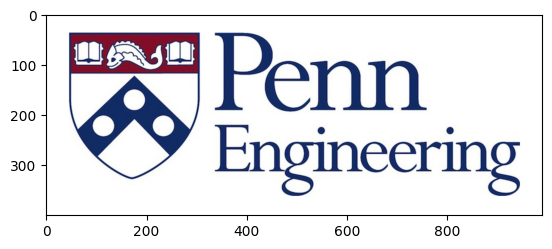

In [10]:
logo_img = cv2.imread('./images/logos/penn_engineering_logo.png')
plt.imshow(cv2.cvtColor(logo_img, cv2.COLOR_BGR2RGB))
y_logo, x_logo, channel = logo_img.shape
#grid off
plt.rcParams['axes.grid'] = False

In [11]:
# load mat file
mat = scipy.io.loadmat('./data/BarcaReal_pts.mat')
video_pts = mat['video_pts']
framecount = video_pts.shape[2]

In [12]:
def get_homography(points_source, points_target):
    u, s, v = np.linalg.svd(get_A(points_source, points_target))
    H = v[-1, :].reshape(3, 3)
    return H


def get_Ai(xi_vector, xi_prime_vector):
    xp = xi_prime_vector[0]
    yp = xi_prime_vector[1]
    wp = xi_prime_vector[2]
    Ai = np.concatenate((np.concatenate((0 * xi_vector, -wp * xi_vector, yp * xi_vector)).reshape(1, 9),
                         np.concatenate((wp * xi_vector, 0 * xi_vector, -xp * xi_vector)).reshape(1, 9))
                        )
    assert (Ai.shape == (2, 9))
    return Ai


def get_A(points_source, points_target):
    N = points_source.shape[0]
    A = np.stack(
        [get_Ai(points_source[i, :].reshape(3, ), points_target[i, :].reshape(3, )) for i in range(N)]).reshape(2 * N, 9)
    return A

In [13]:
def warp_image(source, secondary, H, sourcepts):
    ptoi = pointofinterest(source, sourcepts)
    pt_on_sec = np.matmul(ptoi, H.T)
    # print(pt_on_sec)
    pt_on_sec = np.round(pt_on_sec / pt_on_sec[:, 2].reshape(-1, 1)) - 1
    pt_on_sec = pt_on_sec[:, :-1].astype(int)
    for i in range(pt_on_sec.shape[0]):
        try:
            source[ptoi[i, 1], ptoi[i, 0]] = secondary[pt_on_sec[i, 1], pt_on_sec[i, 0]]
        except:
            print("error on: ", ptoi[i], pt_on_sec[i])
    # source[ptoi] = secondary[pt_on_sec]
    return source
    # plt.imshow(grid.reshape(rows, cols))


def pointofinterest(source, sourcepts):
    rows, cols = source.shape[:2]
    x, y = np.meshgrid(np.arange(cols), np.arange(rows))
    x, y = x.flatten(), y.flatten()
    points = np.vstack((x, y)).T
    p = matplotlib.path.Path(sourcepts)
    grid = p.contains_points(points)
    ptoi = np.array([[x[i], y[i], 1] for i in range(len(x)) if grid[i]]).reshape(-1, 3)
    return ptoi

In [14]:
imageset = []
for i in range(framecount):
    currentimg = cv2.imread('images/barcaReal/BarcaReal' + str(i + 1).zfill(3) + '.jpg')
    currentpts = np.array([[e[0], e[1]] for e in video_pts[:, :, i]])
    imgmod = cv2.polylines(currentimg, np.int32([currentpts]), isClosed=True, color=(255, 0, 0), thickness=2)
    # plt.imshow(cv2.cvtColor(imgmod, cv2.COLOR_BGR2RGB))
    logo_pts = np.array([[0, 0, 1], [x_logo, 0, 1], [x_logo, y_logo, 1], [0, y_logo, 1]])
    H = get_homography(np.hstack((currentpts, np.ones((4, 1)))), logo_pts)
    a = warp_image(currentimg, logo_img, H, currentpts)
    print(i, "of", framecount, 'done')
    imageset.append(a)

0 of 129 done
1 of 129 done
2 of 129 done
3 of 129 done
4 of 129 done
5 of 129 done
6 of 129 done
7 of 129 done
8 of 129 done
9 of 129 done
10 of 129 done
11 of 129 done
12 of 129 done
13 of 129 done
14 of 129 done
15 of 129 done
16 of 129 done
17 of 129 done
18 of 129 done
19 of 129 done
20 of 129 done
21 of 129 done
22 of 129 done
23 of 129 done
24 of 129 done
25 of 129 done
26 of 129 done
27 of 129 done
28 of 129 done
29 of 129 done
30 of 129 done
31 of 129 done
32 of 129 done
33 of 129 done
34 of 129 done
35 of 129 done
36 of 129 done
37 of 129 done
38 of 129 done
39 of 129 done
40 of 129 done
41 of 129 done
42 of 129 done
43 of 129 done
44 of 129 done
45 of 129 done
46 of 129 done
47 of 129 done
48 of 129 done
49 of 129 done
50 of 129 done
51 of 129 done
52 of 129 done
53 of 129 done
54 of 129 done
55 of 129 done
56 of 129 done
57 of 129 done
58 of 129 done
59 of 129 done
60 of 129 done
61 of 129 done
62 of 129 done
63 of 129 done
64 of 129 done
65 of 129 done
66 of 129 done
67 of

In [15]:
#save video from imageset frames
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi', fourcc, 20.0, (imageset[0].shape[1], imageset[0].shape[0]))
for i in range(len(imageset)):
    out.write(imageset[i])

In [17]:
for frame in imageset:
    cv2.imshow('frame', frame)
    time.sleep(0.08)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        cv2.destroyAllWindows()
        break
cv2.destroyAllWindows()